In [2]:
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from tqdm import tqdm
from functools import reduce
import matplotlib.pyplot as plt
import time
import scipy

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 4.0)
ctx = mx.gpu(0)

In [3]:
from rnn_utils import fourier_features, RNNModel, detach, generate_weight_sample

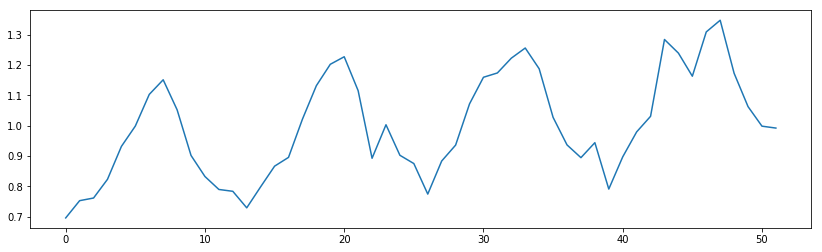

In [4]:
df = pd.read_csv("fourweekly-totals-of-beer-shipme.csv", header=0)
ts = df.values[:,1]
ts = ts/np.mean(ts)
plt.plot(ts);

In [39]:
num_feat=1
num_hidden=5
num_layer=1
num_epochs=2000
f_horizon=50

Use last the lag-1 demand as features ...

In [50]:
xff = nd.array(ts[:-1]).as_in_context(ctx).reshape(shape=(51,1,1))
yff = nd.array(ts[1:]).as_in_context(ctx).reshape(shape=(1,51))

In [51]:
xt = nd.array([ts[-1]]).as_in_context(ctx).reshape((1,1,1))

In [52]:
model = RNNModel("lstm", num_feat, num_hidden, num_layer)
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.01})
l2loss = gluon.loss.L2Loss()
start_time = time.time()

tqdm_epochs = tqdm(range(num_epochs))

for e in tqdm_epochs:
    hidden = model.begin_state(func = mx.nd.zeros, batch_size = 1, ctx=ctx)
    hidden = detach(hidden)
    with autograd.record():
        output, hidden = model(xff, hidden)
        L = l2loss(output.T, yff)
        L.backward()
    trainer.step(1)
    
    tqdm_epochs.set_postfix({"loss": nd.sum(L).asscalar()})
elapsed_time = time.time() - start_time
print("Elapsed time %s" % elapsed_time)

100%|██████████| 2000/2000 [01:27<00:00, 22.79it/s, loss=0.00116]

Elapsed time 87.77601385116577


In [53]:
def rnn_forecast(xt, model, hidden, f_horizon):
    fcst=[]
    for i in range(f_horizon):
        yt, hidden = model(xt, hidden)
        fcst.append(yt.reshape((-1,)).asnumpy()[0])
        xt = yt.reshape((1,1,1))
    return fcst    

def plot_fcst(ts, output, fcst):
    plt.figure()
    plt.plot(np.arange(1, len(ts)+f_horizon), np.array(list(output.reshape((-1,)).asnumpy())+fcst), 'r--'); 
    plt.plot(ts); 
    plt.title("RNN type: %s with num_hidden = %d" % ("lstm", num_hidden))
    plt.grid()

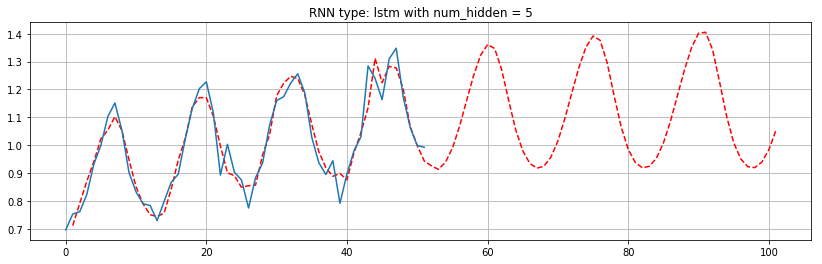

In [54]:
fcst=rnn_forecast(xt, model, hidden, f_horizon)
plot_fcst(ts, output, fcst)

# Now on to the BBB side ....

Let's begin with baby steps! Everything is Gaussian with fixed noise variance ...

In [55]:
class BBBLoss(gluon.loss.Loss):
    def __init__(self,
                 sigma_p=1.0,
                 weight=None, 
                 batch_axis=0, 
                 **kwargs):
        self.sigma_p=sigma_p
        super(BBBLoss, self).__init__(weight, batch_axis, **kwargs)        
    
    def log_like(self, yhat_linear, y):
        sigma = 0.1*nd.ones(shape=yhat_linear.shape)
        return -0.5 * np.log(2.0 * np.pi) - nd.log(sigma) - (yhat_linear - y) ** 2 / (2 * sigma ** 2)

    def log_gaussian(self, x, mu, sigma):
        return -0.5 * np.log(2.0 * np.pi) - nd.log(sigma) - (x - mu) ** 2 / (2 * sigma ** 2)

    def gaussian_prior(self, x):
        sigma_p = nd.array([self.sigma_p], ctx=ctx)
        return nd.sum(self.log_gaussian(x, 0., sigma_p))    
        
    def hybrid_forward(self, F, output, label, params, mus, sigmas, sample_weight=None):
        log_likelihood_vec = self.log_like(output, label) 
        T = log_likelihood_vec.shape[1]        
        log_likelihood_sum = nd.sum(log_likelihood_vec)
        prior = self.gaussian_prior
        log_prior_sum = sum([nd.sum(prior(param)) for param in params])
        log_var_posterior_sum = sum([nd.sum(self.log_gaussian(params[i], mus[i], sigmas[i])) for i in range(len(params))])
        
        return 1.0 / T * (log_var_posterior_sum - log_prior_sum) - log_likelihood_sum

In [56]:
bbb_loss = BBBLoss(sigma_p=1000)
model = RNNModel("lstm", num_feat, num_hidden, num_layer)
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)

## well ... this is crucial. 
weight_scale = 1.0
rho_offset = -2.0

# initialize variational parameters; mean and variance for each weight
mus = []
rhos = []

shapes = list(map(lambda x: x.shape, model.collect_params().values()))

for shape in shapes:
    mu = gluon.Parameter('mu', shape=shape, init=mx.init.Normal(weight_scale))
    rho = gluon.Parameter('rho',shape=shape, init=mx.init.Constant(rho_offset))
    mu.initialize(ctx=ctx)
    rho.initialize(ctx=ctx)
    mus.append(mu)
    rhos.append(rho)

variational_params = mus + rhos

raw_mus = list(map(lambda x: x.data(ctx), mus))
raw_rhos = list(map(lambda x: x.data(ctx), rhos))

In [57]:
trainer = gluon.Trainer(variational_params, 'adam',  {'learning_rate': 0.01})
start_time = time.time()

num_epochs = 10000
tqdm_epochs = tqdm(range(num_epochs))

for e in tqdm_epochs:
    hidden = model.begin_state(func = mx.nd.zeros, batch_size = 1, ctx=ctx)
    hidden = detach(hidden)
    with autograd.record():
        # sample the model parameter
        layer_params, sigmas = generate_weight_sample(shapes, raw_mus, raw_rhos, ctx)
        
        # setup the params
        for sample, param in zip(layer_params, model.collect_params().values()):
            param._data[0] = sample
        
        # then forward and backward
        output, hidden = model(xff, hidden)
        loss = bbb_loss(output.T, yff, layer_params, raw_mus, sigmas)
        l2_loss = l2loss(output.T, yff)
        loss.backward()
        
    trainer.step(1)
    
    tqdm_epochs.set_postfix({"BBB-loss": loss.asscalar(), "l2-loss": l2_loss.asscalar()})    

elapsed_time = time.time() - start_time
print("Elapsed time %s" % elapsed_time)

100%|██████████| 10000/10000 [07:08<00:00, 23.36it/s, BBB-loss=-39.4, l2-loss=0.00185] 

Elapsed time 428.09862327575684


In [58]:
def generate_sample_path(num_samples, f_horizon):
    samples=[]    
    for i in range(num_samples):
        layer_params, sigmas = generate_weight_sample(shapes, raw_mus, raw_rhos, ctx)
        for sample, param in zip(layer_params, model.collect_params().values()):
                    param._data[0] = sample

        hidden = model.begin_state(func = mx.nd.zeros, batch_size = 1, ctx=ctx)
        output, _ = model(xff, hidden)
        
        xt = nd.array([ts[-1]]).as_in_context(ctx).reshape((1,1,1))
        fcst=[]
        for i in range(f_horizon):
            yt, hidden = model(xt, hidden)
            fcst.append(yt.reshape((-1,)).asnumpy()[0])
            xt = yt.reshape((1,1,1))
        
        sample = np.array(list(output.reshape((-1,)).asnumpy())+fcst)        
        samples.append(sample)
    return samples

In [59]:
samples = generate_sample_path(50, 50)

In [60]:
from functools import reduce
import pandas as pd

sample_paths = reduce(lambda x, y: np.vstack((x,y)), samples)
df = pd.DataFrame(sample_paths)
cf = df.quantile([.1, .9]).as_matrix()

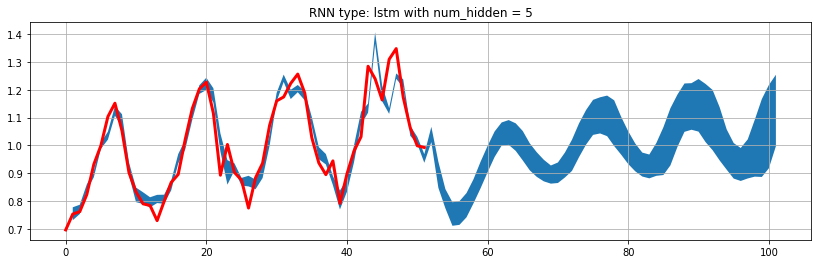

In [61]:
plt.plot(ts, 'r', lw=3);
plt.fill_between(np.arange(1, len(ts)+f_horizon), cf[0,:], cf[1,:])
plt.title("RNN type: %s with num_hidden = %d" % ("lstm", num_hidden))
plt.grid()